<a href="https://colab.research.google.com/github/aquapathos/openCVLesson/blob/master/OpticalFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# オプティカルフローの実験

# 準備

1. まず，この notebook を一度最後まで実行して，実験の概要をつかみなさい．
2. サンプル画像 **ImageA.png** の代わりに各自画像を用意して実験をしてもらいます．
3. [MagicaVoxel](https://ephtracy.github.io/)で対象画像を作成しなさい．そのためにまずダウンロードし解凍しなさい．
4. MagicaVoxel を立ち上げ，![Alt text](https://monosnap.com/image/EzbmZYyEqPQO9EMa3MY6zeSzUqq4RS.png) Project の欄から好きなモデルを選びなさい．自作したり，ネット上のフリー素材を使ってもかまいません．
5. ![Alt text](https://monosnap.com/image/zATgurzwKKlVtOzHFN90Yo1xCQ0ya9.png) 右下のキューブをマウスで操作すると視点が変わります．
6. オブジェクトが画面の縦横の3分の１ぐらいのサイズなるようにし，ほぼ中央に来るようにしなさい．構図が決まったら，Renderモードにきりかえ，画像サイズを320 320 にしなさい．（手入力する）．
![Alt text](https://monosnap.com/image/cz83jGNiMtCJXbsswlMxVD5KUJ8e4f.png)
7. 影があるとオブジェクトを正しく切り出すのが難しくなるので，**Shadow** はオフに，空を含め，背景はオブジェクトより暗くなるように設定しなさい．（GROUND と SKY のカラーを暗い色に設定）．特に空を含める必要はない．
![Alt text](https://monosnap.com/image/9GTQbLVpJlFQpomfn2FYsnRKFp7VRX.png)　わるい例
8. レンダリングが完了したら（青の横線がプログレスバー．右端まで行ったらレンダリング完了）カメラボタンを押して画像を保存しなさい．
9. サンプル画像 ImageA.png を削除し，自分の画像の名前を ImageA.png に書き換えて，左のファイルメニューでアップロードしなさい．
あるいはプログラムのファイル名のところを自分の画像のファイル名に合わせても構いません．


# 課題

1. 下のShi-Tomasi コーナー検出のプログラムで，自分の用意した画像に十分な数の追跡に適した特徴があることを確認しなさい．（もちろんレポートにも記載する）（特徴は10個程度以上あればよい）
2. Lucas-Kanade法によるオプティカルフロー追跡のプログラムのステップ数をさまざまに変化させて，並進運動（平行移動）と回転それぞれ，正しく追跡できる限界を見つけなさい．
3. ほぼ正しく追跡できる<font color='red'>$†$</font>限界の移動間隔（角度の場合は角度差）と結果の例 ，ほとんどの対応が間違ってしまう移動間隔（角度差）と結果の例，中間的な結果（いくつかは正しいが，いくつかは対応を間違っている）とその時の移動間隔（角度差）をレポートしなさい．（並進と角度両方）

　<font color='red'> $†$ 背景に地平線が含まれる場合で回転運動が水平線を横切るときには，オブジェクトと背景との交点にそれまでなかった特徴点が発生し対応を見失う．これは避けられないので，回転についてはそのような個所は評価の対象外とせよ．</font>



In [1]:
import cv2
import requests
import tempfile
res = requests.get("https://user-images.githubusercontent.com/5820803/63912723-62aedc80-ca1d-11e9-9b1a-6fd509637ace.png")
with tempfile.NamedTemporaryFile(dir='./') as fp:
        fp.write(res.content)
        fp.file.seek(0)
        snap = cv2.imread(fp.name)
cv2.imwrite('ImageA.png',snap)

True

https://ephtracy.github.io/

In [0]:
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}
from IPython.display import IFrame
from IPython.display import HTML
from IPython.display import display
from matplotlib.animation import FuncAnimation

# IPython.display アニメーションの定義
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 50 # アニメの容量制限を50MBにアップ

def makeAnimation(frames,step=1):
    fig = plt.figure(figsize=(frames[0].shape[1]/100, frames[0].shape[0]/100), dpi=100,frameon=False)
    ax = fig.add_axes([0.,0.,1.,1.])
    plt.axis('off')
    patch = plt.imshow(frames[0][:,:,::-1])
        
    def animate(i):
        patch.set_data(frames[i][:,:,::-1])
    
    anim = FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=1000/(120.0/step))
    display(HTML(anim.to_jshtml()))

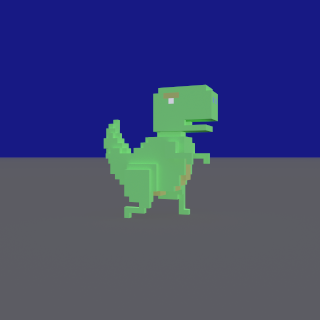

図１　原画像


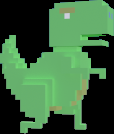

図２　オブジェクト


In [3]:
base = cv2.imread("ImageA.png",1)
base_gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
(h,w) = base_gray.shape
flag = (base_gray[h-1,w-1] < base_gray[0,0]) # 背景の濃度
base0 = base[0,0] if flag else base[h-1,w-1] 
gray0 = base_gray[0,0] if flag else base_gray[h-1,w-1] 
display(Image.fromarray(base[:,:,::-1]))
print("図１　原画像")
ret,cimg = cv2.threshold(base_gray,gray0+5,255,cv2.THRESH_BINARY)
nLabels, labelImages, data, center = cv2.connectedComponentsWithStats(cimg)
bindex = np.argmax(data[:,4])
limg = ((labelImages!=bindex)*255).astype(np.uint8)
imgEdge,contours,hierarchy = cv2.findContours(limg, 1, 2)
maxcon = np.argmax( [len(con) for con in contours])
con = contours[maxcon]
x,y,ow,oh = cv2.boundingRect(con)
object = base[y:y+oh,x:x+ow]
object = object*(np.where(labelImages[y:y+oh,x:x+ow]==bindex,0,1)[:,:,np.newaxis].astype('uint8'))
display(Image.fromarray(object[:,:,::-1]))
print("図２　オブジェクト")

# Shi-Tomasi コーナー検出
この実験で用いるLucus-Kanade 法では，コーナーなどの追跡しやすい特徴点のみを追跡する． よい特徴として，Harris コーナーや，Shi-Tomasiのコーナーがよくつかわれる． OpenCV の goodFeaturesToTrack()関数は，Shi-Tomasiのコーナー検出が実装されている．

オプティカルフロー検出を試みる前に，goodFeaturesToTrack()でどのような箇所が検出されるか見ておこう．

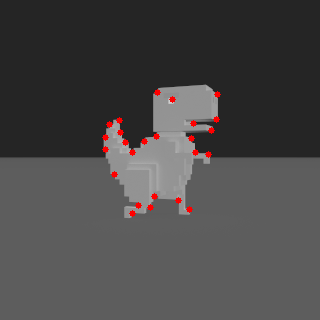

図３　Good Features = Shi-Tomasiコーナー


In [4]:
import requests
import tempfile

corners = cv2.goodFeaturesToTrack(base_gray,25,0.01,10)
corners = np.int0(corners)

gray = cv2.cvtColor(base_gray,cv2.COLOR_GRAY2BGR)
for i in corners:
    x,y = i.ravel()
    cv2.circle(gray,(x,y),3,(0,0,255),-1)

display(Image.fromarray(gray[:,:,::-1]))
print("図３　Good Features = Shi-Tomasiコーナー")


<font color='red'>もし，良い特徴の数が少ないようであれば，入力図形を変更すること．</font>

# 疑似動画生成１　並進運動

In [0]:
movie = []
bimg = np.zeros((320,640,3),np.uint8)
for line in range(bimg.shape[0]): # 背景を作る
    bimg[line,:] = base[line,0]
mask = np.where(object>0,0,255).astype(np.uint8)
for i in range(5,635-ow): # 
    img = bimg.copy()
    sh = 160-int(oh/2)
    crip = img[sh:sh+oh,i:i+ow,:]
    crip = cv2.bitwise_and(crip,mask,crip) 
    img[sh:sh+oh,i:i+ow,:] = cv2.add(crip,object) 
    movie.append(img)

makeAnimation(frames=movie)                   

# 疑似動画生成２　回転運動

In [0]:
(oh,ow)=object.shape[:2]
rimg = np.zeros((480,480,3),np.uint8)
offset = -30
ocx,ocy = ow-offset,offset # オブジェクトを囲むボックスの右上から内側に(offset,offset)入った点を中心にする
cx,cy = 240,240 # 図形全体の中心
dx,dy = cx - ocx, cy - ocy # 
rimg[dy:dy+oh,dx:dx+ow] = object # 回転の初期位置

base480 = cv2.resize(base,(480,480))
bimg = np.zeros_like(base480)
for line in range(len(base480)): # 背景を作る
    bimg[line,:] = base480[line,0]

amovie = []
for angle in range(360): # 
    trans = cv2.getRotationMatrix2D((cx,cy), angle, scale=1.0)
    oimg = cv2.warpAffine(rimg, trans, (480,480))
    mask = np.where(oimg>0,0,255).astype(np.uint8)
    bimg1 = bimg.copy()
    bimg1 = cv2.bitwise_and(bimg1,mask,bimg1) 
    img = cv2.add(oimg,bimg1)
    amovie.append(img)
# 360度を超える角度の場合，（angle -360度）と同じになる．少し余分に作っておく    
for angle in range(360,405):
    amovie.append(amovie[angle-360])
    
makeAnimation(frames=amovie) 

# Lucas-Kade法によるオプティカルフロー追跡
## 並進移動の場合

In [0]:
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 30,
                       qualityLevel = 0.01,
                       minDistance = 9,
                       blockSize = 3 )
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (10,10),
                  maxLevel = 5,
                  criteria = (cv2.TERM_CRITERIA_MAX_ITER|cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 20,.05))
# Create some random colors
color = np.random.randint(0,255,(100,3))
# Take first frame and find corners in it

def showOF(anim,step=1):
    old_frame = anim[0]
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
    # Create a mask image for drawing purposes
    mask = np.zeros_like(old_frame)

    frames = []
    for i in range(step,len(anim),step):
        frame = anim[i]
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
        # Select good points
        good_new = p1[st==1]
        good_old = p0[st==1]
        # draw the tracks
        for i,(new,old) in enumerate(zip(good_new,good_old)):
            a,b = new.ravel()
            c,d = old.ravel()
            mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
            # frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
        img = cv2.add(frame,mask)
        frames.append(img)
        # Now update the previous frame and previous points
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1,1,2)

    # 動画表示
    makeAnimation(frames=frames,step=step) # 

In [0]:
showOF(anim=movie,step=110)  # step はフレーム間隔

In [0]:
# ２つのフレームのマッチング
def drawCorr(anim=movie,A=0,B=1):
    
    display(Image.fromarray(anim[A][:,:,::-1]))
    print("フレームA")
    display(Image.fromarray(anim[B][:,:,::-1]))
    print("フレームB")
    
    old_frame = anim[A].copy()
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    new_frame = anim[B].copy()
    new_gray = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)

    # drawing colors
    yellow = (255,255,0)
    red = (255,0,0)
    blue = (0,0,255)

    # Take first frame and find corners in it
    p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

    # Create a mask image for drawing purposes
    mask = np.zeros_like(old_frame)

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, new_gray, p0, None, **lk_params)

    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]

    old_frame[...,0]=0
    new_frame[...,1]=0

    blended = cv2.addWeighted(src1=old_frame,alpha=1,src2=new_frame,beta=1,gamma=0)

    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (a,b),(c,d), yellow, 1)
        frame = cv2.circle(blended,(a,b),2,red,-1)
        frame = cv2.circle(frame,(c,d),2,blue,-1)
    img = cv2.add(frame,mask)

    display(Image.fromarray(img))
    print("特徴点マッチング結果")

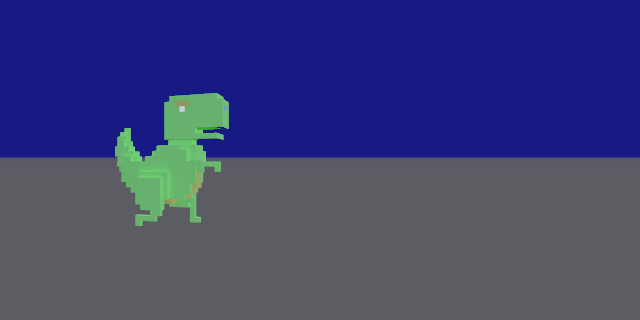

フレームA


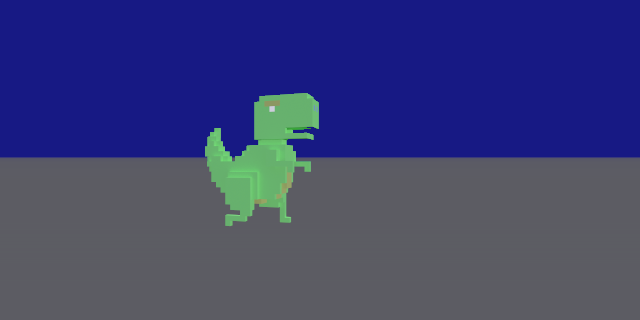

フレームB


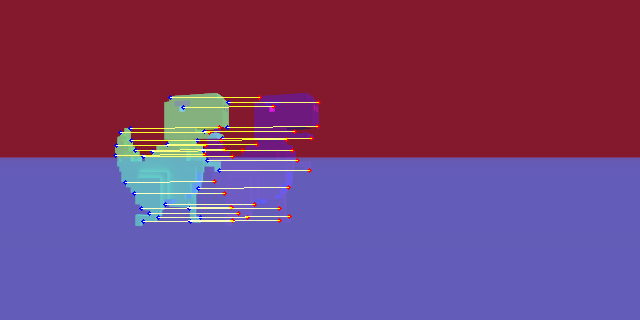

特徴点マッチング結果


In [10]:
drawCorr(anim=movie,A=110,B=200)

# 回転運動の場合

In [0]:
showOF(anim=amovie,step=5)  # step はフレーム間隔

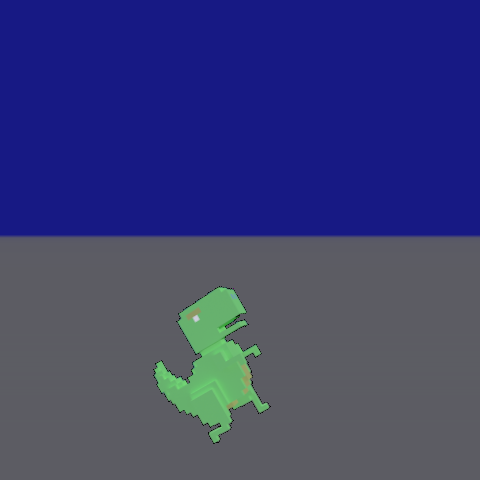

フレームA


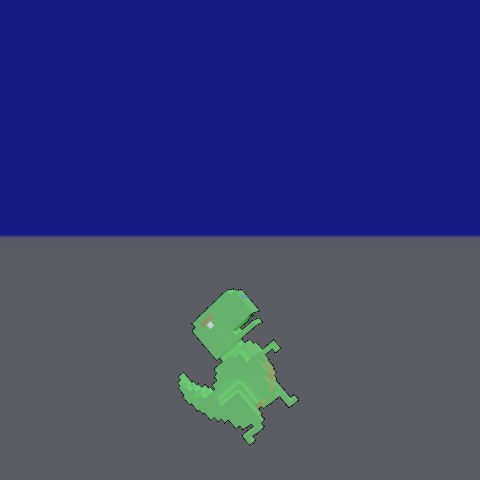

フレームB


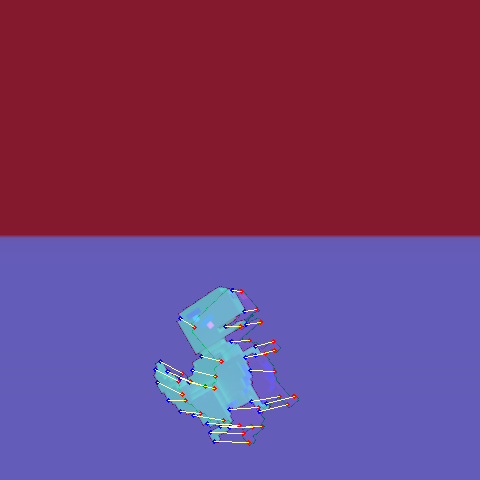

特徴点マッチング結果


In [12]:
drawCorr(anim=amovie,A=30,B=40)

# おまけ 
以下のプログラムは，密なオプティカルフロー追跡

色の違いは移動方向の違いを表す

In [0]:
cap = movie
(h,w) = cap[0].shape[:2]

NOMOVE = 0.9

def draw_flow(img, flow, step=16):
    global w,h
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[...,0] = ang*(180/np.pi/2)
    hsv[...,1] = 255
    # hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    hsv[...,2][mag>NOMOVE] = 255 
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    for (x1, y1), (x2, y2) in lines:
        color = (int(bgr[y1,x1,0]),int(bgr[y1,x1,1]),int(bgr[y1,x1,2]))
        # cv2.circle(vis, (x1, y1), 1, color, -1)
        cv2.line(vis,(x1,y1),(x2,y2), color ,1)
    return vis
    
prev = cap[0]
prevgray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)    

offrames = []
for img in movie[1:]:           
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prevgray, gray, None, pyr_scale = 0.5,levels = 3, 
             winsize = 15, iterations = 3, poly_n = 5, poly_sigma = 1.1, flags = 0)
    prevgray = gray
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    dimg = draw_flow(gray, flow, step=8)
    offrames.append(dimg)

# 動画表示
makeAnimation(frames=offrames)  # 

In [0]:
cap = amovie
(h,w) = cap[0].shape[:2]
# 動画表示
prev = cap[0]
prevgray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)    

offrames = []
for img in amovie[1:]:           
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prevgray, gray, None, pyr_scale = 0.5,levels = 3, 
             winsize = 15, iterations = 3, poly_n = 5, poly_sigma = 1.1, flags = 0)
    prevgray = gray
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    dimg = draw_flow(gray, flow, step=8)
    offrames.append(dimg)

# 動画表示
makeAnimation(frames=offrames)  # 